In [1]:
GPU = True #set to True to use GPU for XGboost and LightGBM

### Baseline Models

Simple If-Then Models

 - Home team always wins (Accuracy = 0.59, AUC = 0.50 on Train data, Accuracy = 0.49, AUC = 0.50 on Test data)

 
ML Models

 - LightGBM (Accuracy = 0.58, AUC = 0.64 on Test data)
 - XGBoost (Accuracy = 0.59, AUC = 0.61 on Test data)
    

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
print('XGB version:', xgb.__version__)

import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
print('LGB version:', lgb.__version__)

from tqdm import tqdm

import shap

import matplotlib.pyplot as plt
import seaborn as sns



XGB version: 2.0.2
LGB version: 4.1.0


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [124]:
# DATAPATH = '/content/drive/MyDrive/20231/Nhập môn Khoa học dữ liệu/Project/data'

In [15]:
df = pd.read_csv('C:/Users/ngtdu/Downloads/transformed.csv')

In [16]:
latest_season = df['SEASON'].unique().max()

train = df[df['SEASON'] < (latest_season)]
test = df[df['SEASON'] >= (latest_season - 1)]

# train.to_csv(f'{DATAPATH}/train.csv',index=False)
# test.to_csv(f'{DATAPATH}/test.csv',index=False)

In [125]:
# train = pd.read_csv(DATAPATH + "train.csv")
# test = pd.read_csv(DATAPATH + "test.csv")

# train.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,PLAYOFF,TARGET
0,2022-03-12,22101005,1610612748,1610612750,2021,104.0,0.398,0.760,0.333,23.0,53.0,113.0,0.422,0.875,0.357,21.0,46.0,0,0,0
1,2022-03-12,22101006,1610612741,1610612739,2021,101.0,0.443,0.933,0.429,20.0,46.0,91.0,0.419,0.824,0.208,19.0,40.0,1,0,1
2,2022-03-12,22101007,1610612759,1610612754,2021,108.0,0.412,0.813,0.324,28.0,52.0,119.0,0.489,1.000,0.389,23.0,47.0,0,0,0
3,2022-03-12,22101008,1610612744,1610612749,2021,122.0,0.484,0.933,0.400,33.0,55.0,109.0,0.413,0.696,0.386,27.0,39.0,1,0,1
4,2022-03-12,22101009,1610612743,1610612761,2021,115.0,0.551,0.750,0.407,32.0,39.0,127.0,0.471,0.760,0.387,28.0,50.0,0,0,0


**Model - Home team always wins**

In [6]:
# train data

predict = predict = np.ones((train.shape[0],))
true =  train['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.5905921980260066, 0.5)

In [7]:
# test data

predict = predict = np.ones((test.shape[0],))
true =  test['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.5808903365906624, 0.5)

### ML Baseline Models

**Fix Datatypes for smaller memory footprint**

In [17]:
def fix_datatypes(df):
    
    # df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

    long_integer_fields = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

    #convert long integer fields to int32 from int64
    for field in long_integer_fields:
        df[field] = df[field].astype('int32')
    
    #convert the remaining int64s to int8
    for field in df.select_dtypes(include=['int64']).columns.tolist():
        df[field] = df[field].astype('int8')
        
    #convert float64s to float16s
    for field in df.select_dtypes(include=['float64']).columns.tolist():
        df[field] = df[field].astype('float16')
        
    return df

train = fix_datatypes(train)
test = fix_datatypes(test)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

**Basic Feature Engineering**

Because the basic data is post-game data, there would be data leakage if we used the data as is. We need to create features that are available before the game starts. Namely, we will do a rolling average for each stat for the last 5 games.

In [18]:
def add_rolling_means(df, location):

    location_id = location + "_TEAM_ID"

    df = df.sort_values(by = [location_id, 'GAME_DATE_EST'], axis=0, ascending=[True, True,], ignore_index=True)

    # rolling means
    feature_list = ['HOME_TEAM_WINS', 'PTS_home', 'FGM_home', 'FGA_home', 'FG_PCT_home', '3PM_home', '3PA_home', 'FG3_PCT_home', 'FTM_home',
                    'FTA_home', 'FT_PCT_home', 'OREB_home', 'DREB_home', 'REB_home', 'AST_home', 'STL_home', 'BLK_home', 'TOV_home', 'PF_home', '+/-_home']

    if location == 'VISITOR':
        feature_list = ['HOME_TEAM_WINS', 'PTS_away', 'FGM_away', 'FGA_away', 'FG_PCT_away', '3PM_away', '3PA_away', 'FG3_PCT_away', 'FTM_away',
                        'FTA_away', 'FT_PCT_away', 'OREB_away', 'DREB_away', 'REB_away', 'AST_away', 'STL_away', 'BLK_away', 'TOV_away', 'PF_away', '+/-_away']

    roll_feature_list = []
    for feature in feature_list:
        roll_feature_name = location + '_' + feature + '_AVG_LAST_' + '5_' + location
        if feature == 'HOME_TEAM_WINS': #remove the "HOME_" for better readability
            roll_feature_name = location + '_' + feature[5:] + '_AVG_LAST_' + '5_' + location
        roll_feature_list.append(roll_feature_name)
        df[roll_feature_name] = df.groupby(['HOME_TEAM_ID'])[feature].rolling(5, closed= "left").mean().values

    return df

train = add_rolling_means(train, 'HOME')
train = add_rolling_means(train, 'VISITOR')
test = add_rolling_means(test, 'HOME')
test = add_rolling_means(test, 'VISITOR')

train

,Team_home,GAME_DATE_EST,HOME_TEAM_WINS,MIN_home,PTS_home,FGM_home,FGA_home,FG_PCT_home,3PM_home,3PA_home,FG3_PCT_home,FTM_home,FTA_home,FT_PCT_home,OREB_home,DREB_home,REB_home,AST_home,STL_home,BLK_home,TOV_home,PF_home,+/-_home,HOME_TEAM_ID,GAME_ID,Team_away,MIN_away,PTS_away,FGM_away,FGA_away,FG_PCT_away,3PM_away,3PA_away,FG3_PCT_away,FTM_away,FTA_away,FT_PCT_away,OREB_away,DREB_away,REB_away,AST_away,STL_away,BLK_away,TOV_away,PF_away,+/-_away,VISITOR_TEAM_ID,SEASON,PLAYOFF,TARGET,HOME_TEAM_WINS_AVG_LAST_5_HOME,HOME_PTS_home_AVG_LAST_5_HOME,HOME_FGM_home_AVG_LAST_5_HOME,HOME_FGA_home_AVG_LAST_5_HOME,HOME_FG_PCT_home_AVG_LAST_5_HOME,HOME_3PM_home_AVG_LAST_5_HOME,HOME_3PA_home_AVG_LAST_5_HOME,HOME_FG3_PCT_home_AVG_LAST_5_HOME,HOME_FTM_home_AVG_LAST_5_HOME,HOME_FTA_home_AVG_LAST_5_HOME,HOME_FT_PCT_home_AVG_LAST_5_HOME,HOME_OREB_home_AVG_LAST_5_HOME,HOME_DREB_home_AVG_LAST_5_HOME,HOME_REB_home_AVG_LAST_5_HOME,HOME_AST_home_AVG_LAST_5_HOME,HOME_STL_home_AVG_LAST_5_HOME,HOME_BLK_home_AVG_LAST_5_HOME,HOME_TOV_home_AVG_LAST_5_HOME,HOME_PF_home_AVG_LAST_5_HOME,HOME_+/-_home_AVG_LAST_5_HOME,VISITOR_TEAM_WINS_AVG_LAST_5_VISITOR,VISITOR_PTS_away_AVG_LAST_5_VISITOR,VISITOR_FGM_away_AVG_LAST_5_VISITOR,VISITOR_FGA_away_AVG_LAST_5_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_5_VISITOR,VISITOR_3PM_away_AVG_LAST_5_VISITOR,VISITOR_3PA_away_AVG_LAST_5_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_5_VISITOR,VISITOR_FTM_away_AVG_LAST_5_VISITOR,VISITOR_FTA_away_AVG_LAST_5_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_5_VISITOR,VISITOR_OREB_away_AVG_LAST_5_VISITOR,VISITOR_DREB_away_AVG_LAST_5_VISITOR,VISITOR_REB_away_AVG_LAST_5_VISITOR,VISITOR_AST_away_AVG_LAST_5_VISITOR,VISITOR_STL_away_AVG_LAST_5_VISITOR,VISITOR_BLK_away_AVG_LAST_5_VISITOR,VISITOR_TOV_away_AVG_LAST_5_VISITOR,VISITOR_PF_away_AVG_LAST_5_VISITOR,VISITOR_+/-_away_AVG_LAST_5_VISITOR
0,NOH,2003-10-29,1,9,88,35,108,32.40625,4,25,16.000000,14,20,70.0000,21,34,55,24,18,4,11,20,5,1610612740,20300006,ATL,9,83,33,83,39.81250,3,14,21.406250,14,19,73.68750,10,48,58,18,7,11,25,20,-5,1610612737,2003,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHI,2003-10-31,1,-16,100,36,90,40.00000,6,12,50.000000,22,29,75.8750,16,37,53,27,10,12,14,21,6,1610612741,20300024,ATL,-16,94,36,90,40.00000,7,12,58.312500,15,21,71.37500,13,35,48,22,6,7,15,29,-6,1610612737,2003,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GSW,2003-11-05,1,-16,99,37,83,44.59375,5,18,27.796875,20,31,64.5000,16,36,52,23,10,2,14,20,27,1610612744,20300060,ATL,-16,72,29,79,36.68750,4,12,33.312500,10,20,50.00000,13,30,43,19,8,4,19,25,-27,1610612737,2003,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POR,2003-11-08,1,-16,90,37,87,42.50000,7,14,50.000000,9,10,90.0000,11,30,41,28,7,6,9,10,7,1610612757,20300084,ATL,-16,83,35,80,43.81250,2,20,10.000000,11,14,78.62500,12,33,45,21,6,7,14,11,-7,1610612737,2003,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SEA,2003-11-09,0,-16,81,33,87,37.90625,1,18,5.601562,14,19,73.6875,16,30,46,12,14,5,16,21,-10,1610612760,20300089,ATL,-16,91,34,71,47.90625,8,15,53.312500,15,19,78.87500,9,32,41,16,12,7,21,17,10,1610612737,2003,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [19]:
train = train.dropna().reset_index(drop=True)
test = test.dropna().reset_index(drop=True)

**Select Features**

In [20]:
target = train['TARGET']
test_target = test['TARGET']

category_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS', 'PLAYOFF', 'CONFERENCE_x', 'CONFERENCE_y',]

all_columns = train.columns.tolist()
drop_columns = ['TARGET', 'GAME_DATE_EST', 'GAME_ID', 'Team_home', 'Team_away'] #not really useful as-is

# non-rolling features, which would be data leakage
drop_columns1 = ['HOME_TEAM_WINS', 'PTS_home', 'FGM_home', 'FGA_home', 'FG_PCT_home', '3PM_home', '3PA_home', 'FG3_PCT_home', 'FTM_home',
                    'FTA_home', 'FT_PCT_home', 'OREB_home', 'DREB_home', 'REB_home', 'AST_home', 'STL_home', 'BLK_home', 'TOV_home', 'PF_home', '+/-_home']
drop_columns2 = ['PTS_away', 'FGM_away', 'FGA_away', 'FG_PCT_away', '3PM_away', '3PA_away', 'FG3_PCT_away', 'FTM_away',
                        'FTA_away', 'FT_PCT_away', 'OREB_away', 'DREB_away', 'REB_away', 'AST_away', 'STL_away', 'BLK_away', 'TOV_away', 'PF_away', '+/-_away']

drop_columns = drop_columns + drop_columns1
drop_columns = drop_columns + drop_columns2

use_columns = [item for item in all_columns if item not in drop_columns]

train = train[use_columns]
test = test[use_columns]

**Options**

In [21]:
K_FOLDS = 5
SEED = 13

### LightGBM


In [ ]:
%%time

NUM_BOOST_ROUND = 700
EARLY_STOPPING = 200
LOG_EVALUATION = 100

train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
#train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))
test_preds_shap = 0

lgb_params= {
            'seed': SEED,
            'verbose': 0,           
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc', 

            }

gpu_params= {
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
             }

if GPU:
    lgb_params = lgb_params | gpu_params
    

# K-fold cross validation

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    train_lgbdataset = lgb.Dataset(train_df, label=train_target,)
    val_lgbdataset = lgb.Dataset(val_df, label=val_target, reference = train_lgbdataset )

    model =  lgb.train(lgb_params, 
                       train_lgbdataset,
                       valid_sets=val_lgbdataset,
                       num_boost_round = NUM_BOOST_ROUND,
                       callbacks=[log_evaluation(LOG_EVALUATION),early_stopping(EARLY_STOPPING,verbose=False)],
                       #verbose_eval= VERBOSE_EVAL,
                      )

    temp_oof = model.predict(val_df)
    temp_oof_shap = model.predict(val_df, pred_contrib=True)
    
    temp_test = model.predict(test)
    temp_test_shap = model.predict(test, pred_contrib=True)

    train_oof[val_ind] = temp_oof
    test_preds += temp_test/K_FOLDS

    train_oof_shap[val_ind, :] = temp_oof_shap
    test_preds_shap += temp_test_shap/K_FOLDS
    

    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    fpr, tpr, thresholds = roc_curve(val_target,temp_oof)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    temp_oof_binary = (temp_oof > optimal_threshold).astype(int)

    print(accuracy_score(val_target, temp_oof_binary), roc_auc_score(val_target, temp_oof))
    

    
# Out-of-Fold composite for train data

fpr, tpr, thresholds = roc_curve(target,train_oof)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
train_oof_binary = (train_oof > optimal_threshold).astype(int)

print()
print("Composite Train OOF CV Scores:")
print()
print("Accuracy Score:",accuracy_score(target, train_oof_binary))
print("AUC Score:", roc_auc_score(target, train_oof))
print("Optimal Threshold:", optimal_threshold)

#scores for Test data

test_preds_binary = (test_preds > optimal_threshold).astype(int)
print()
print("Test data Scores:")
print()
print("Accuracy Score:",accuracy_score(test_target, test_preds_binary))
print("AUC Score:", roc_auc_score(test_target, test_preds))





**Feature Importance via Split - the number of times a feature is used in the model**

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

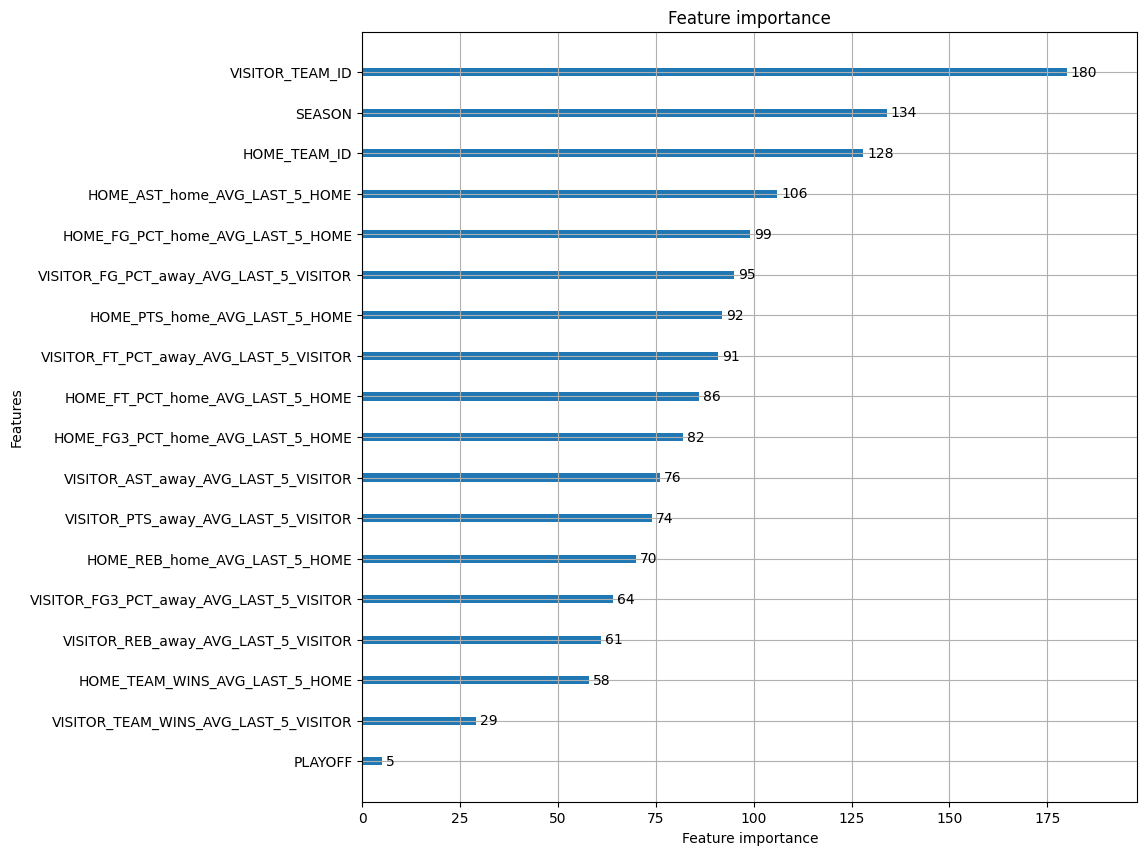

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
lgb.plot_importance(model, importance_type='split', ax=ax)

**Feature Importance via Gain - the average gain of splits which use the feature**

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

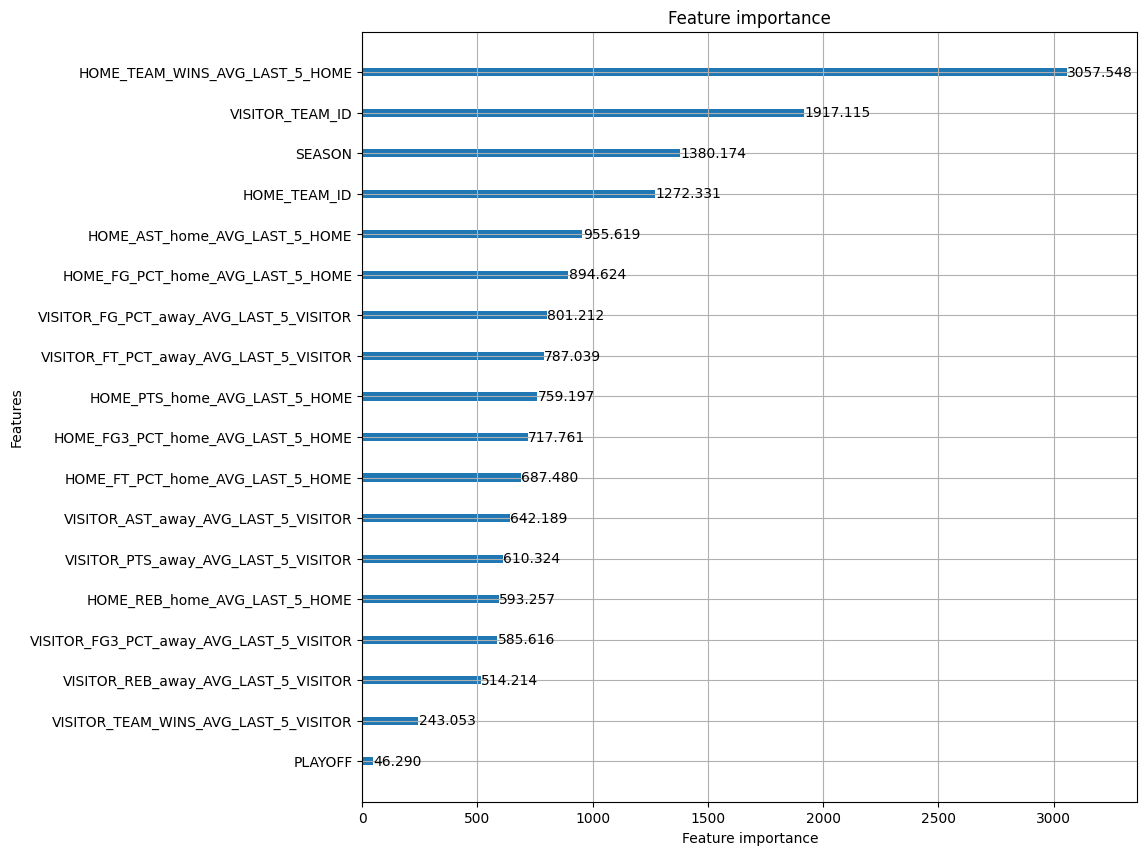

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
lgb.plot_importance(model, importance_type='gain', ax=ax)

**Feature Importance via Shapley values**

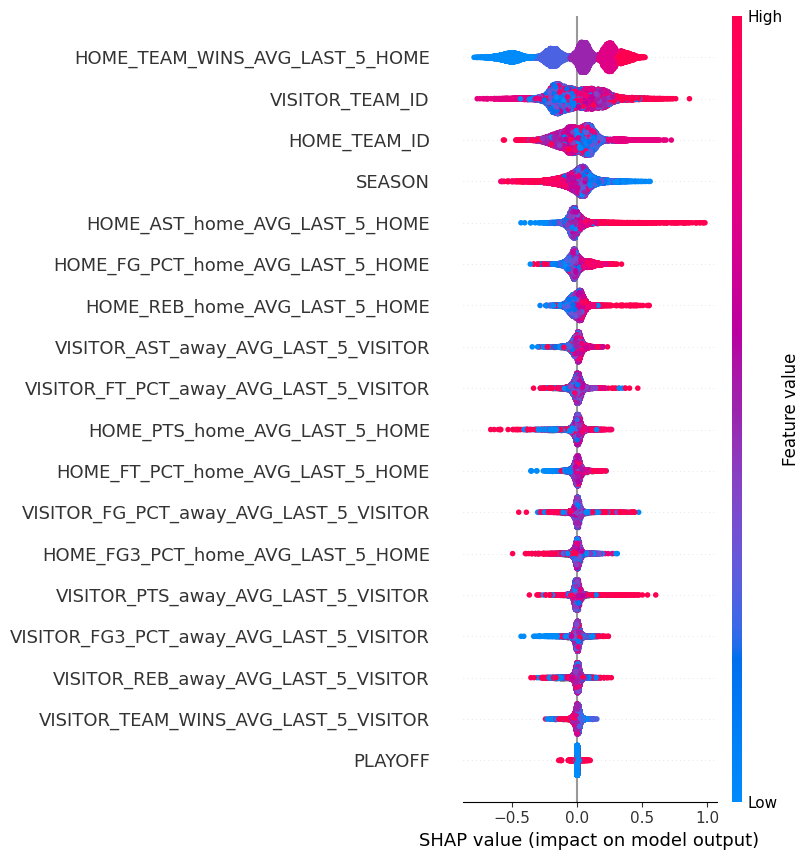

In [ ]:
# summarize the effects of all the features
shap.summary_plot(train_oof_shap[:,:-1], train)

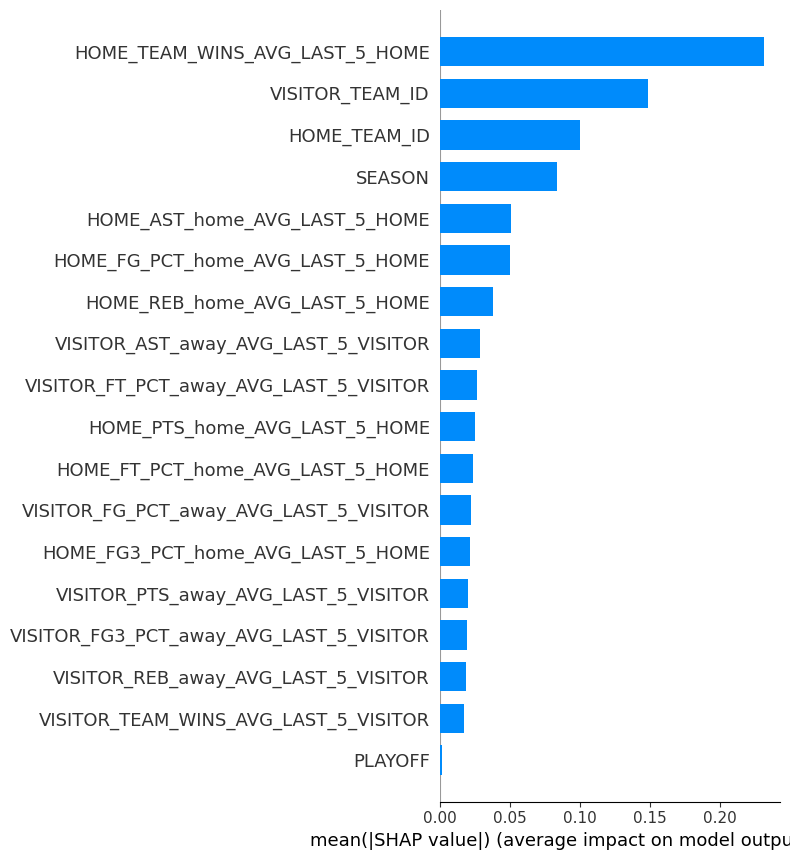

In [ ]:
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")

### XGBoost


In [22]:
%%time

NUM_BOOST_ROUND = 700

train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))
test_preds_shap = 0

xgb_params= {
            'seed': SEED,
            'eval_metric': 'auc',
            }

gpu_params= {
             'tree_method': 'hist',
             'device': 'cuda',
             }

if GPU:
    xgb_params = xgb_params | gpu_params
    

# K-fold cross validation

test_dmatrix = xgb.DMatrix(test)

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    train_dmatrix = xgb.DMatrix(train_df, label=train_target)
    val_dmatrix = xgb.DMatrix(val_df, label=val_target)

    model =  xgb.train(xgb_params, 
                       train_dmatrix, 
                       num_boost_round = NUM_BOOST_ROUND,
                      )

    temp_oof = model.predict(val_dmatrix)
    temp_oof_shap = model.predict(val_dmatrix, pred_contribs=True)
    temp_oof_shap_interact = model.predict(val_dmatrix, pred_interactions=True)
    
    temp_test = model.predict(test_dmatrix)
    temp_test_shap = model.predict(test_dmatrix, pred_contribs=True)

    train_oof[val_ind] = temp_oof
    test_preds += temp_test/K_FOLDS

    train_oof_shap[val_ind, :] = temp_oof_shap
    train_oof_shap_interact[val_ind, :,:] = temp_oof_shap_interact
    test_preds_shap += temp_test_shap/K_FOLDS
    
    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    fpr, tpr, thresholds = roc_curve(val_target,temp_oof)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    temp_oof_binary = (temp_oof > optimal_threshold).astype(int)

    print(accuracy_score(val_target, temp_oof_binary), roc_auc_score(val_target, temp_oof))
    

    
# Out-of-Fold composite for train data

fpr, tpr, thresholds = roc_curve(target,train_oof)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
train_oof_binary = (train_oof > optimal_threshold).astype(int)

print()
print("Composite Train OOF CV Scores:")
print()
print("Accuracy Score:",accuracy_score(target, train_oof_binary))
print("AUC Score:", roc_auc_score(target, train_oof))
print("Optimal Threshold:", optimal_threshold)

#scores for Test data

test_preds_binary = (test_preds > optimal_threshold).astype(int)
print()
print("Test data Scores:")
print()
print("Accuracy Score:",accuracy_score(test_target, test_preds_binary))
print("AUC Score:", roc_auc_score(test_target, test_preds))



0it [00:00, ?it/s]

[21:19:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
1it [18:26, 1106.60s/it]

0.5642447040190062 0.5600663849451841


[21:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
2it [36:55, 1108.00s/it]

0.558305286081964 0.5654330009495137


[21:56:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
3it [56:09, 1128.99s/it]

0.5755295980993863 0.5526737777259196


[22:16:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
4it [1:15:50, 1149.35s/it]

0.5413861386138614 0.5599578510521026


[22:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
5it [1:36:05, 1153.16s/it]

0.5562376237623763 0.5589914243102162

Composite Train OOF CV Scores:

Accuracy Score: 0.5485684869124461
AUC Score: 0.5594780231392207
Optimal Threshold: 0.5802070498466492

Test data Scores:

Accuracy Score: 0.631074168797954
AUC Score: 0.7060005135098397
CPU times: total: 9h 33min 46s
Wall time: 1h 36min 5s


**Feature Importance via Weight - the number of times a feature appears in a tree**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

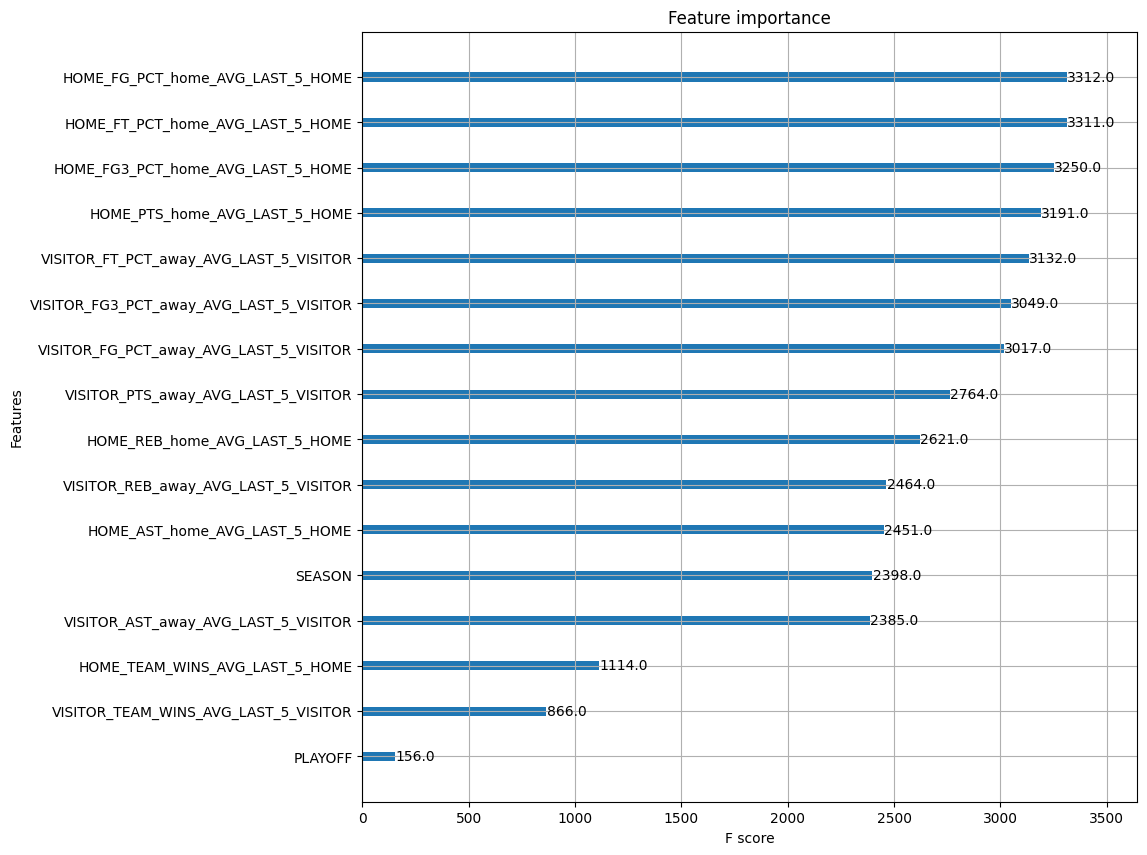

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='weight', ax=ax)

**Feature Importance via Gain - the average gain of splits which use the feature**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

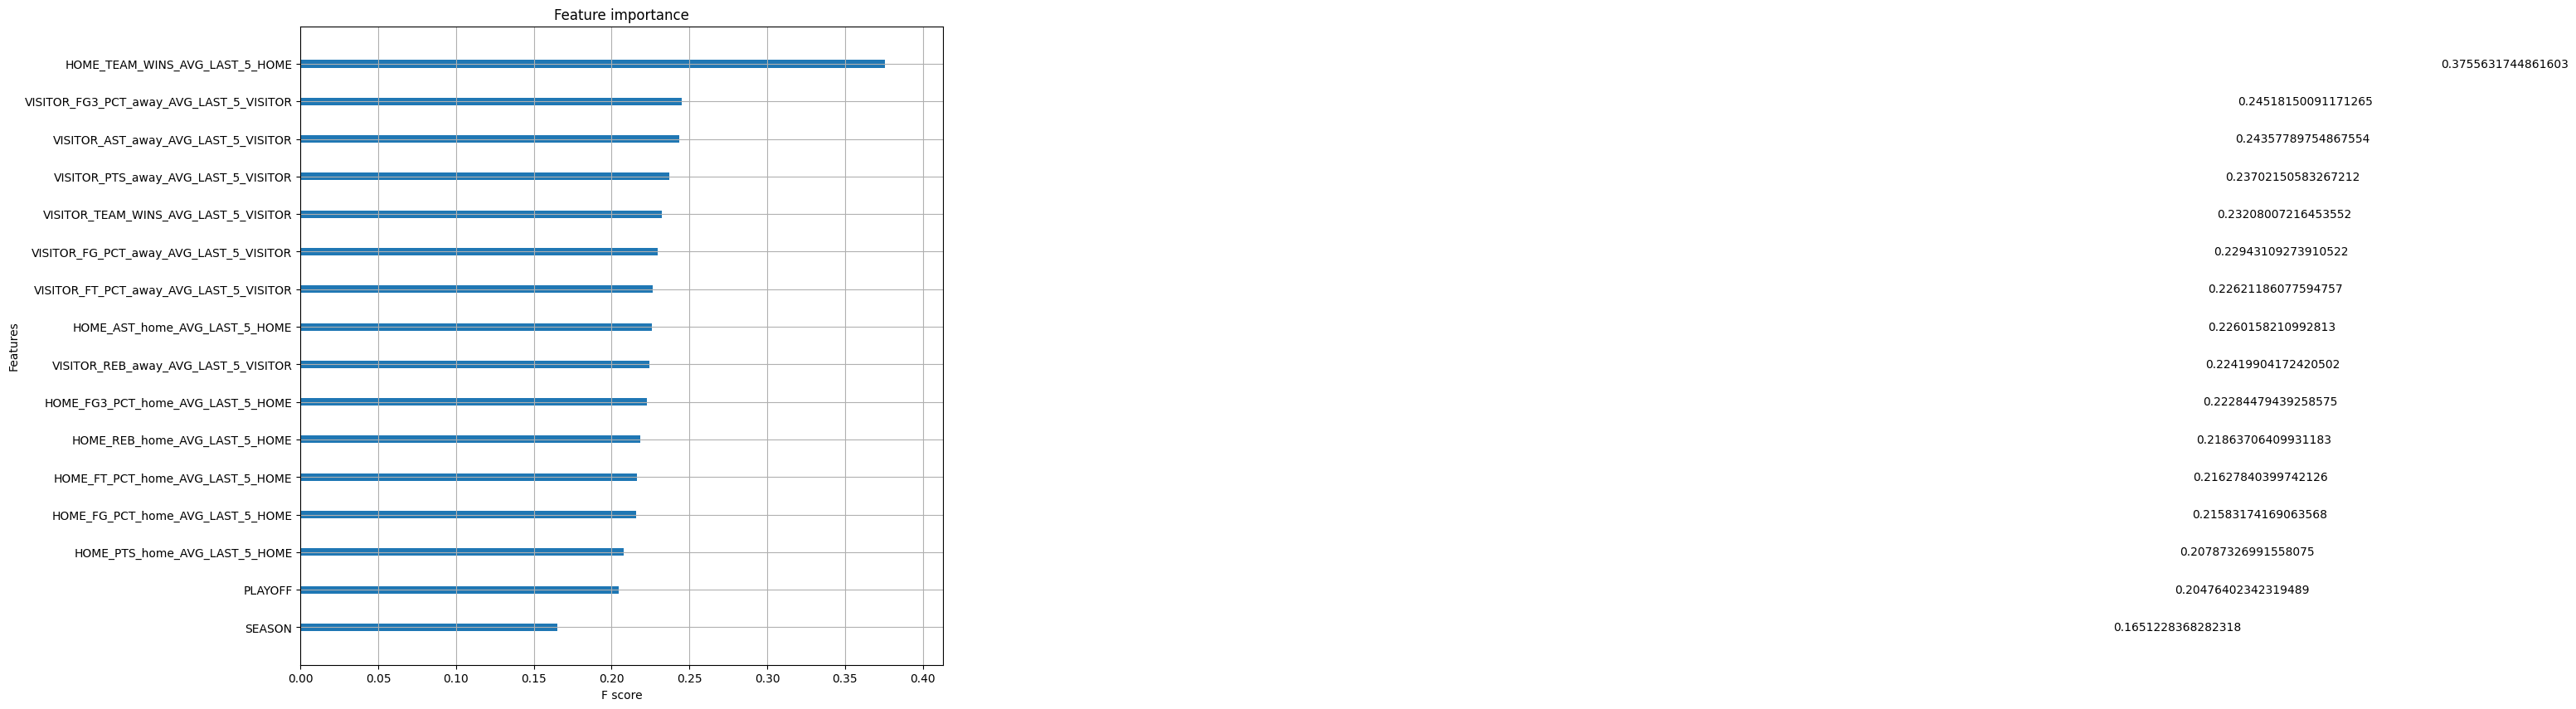

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='gain', ax=ax)

**Feature Importance via Shapley values**

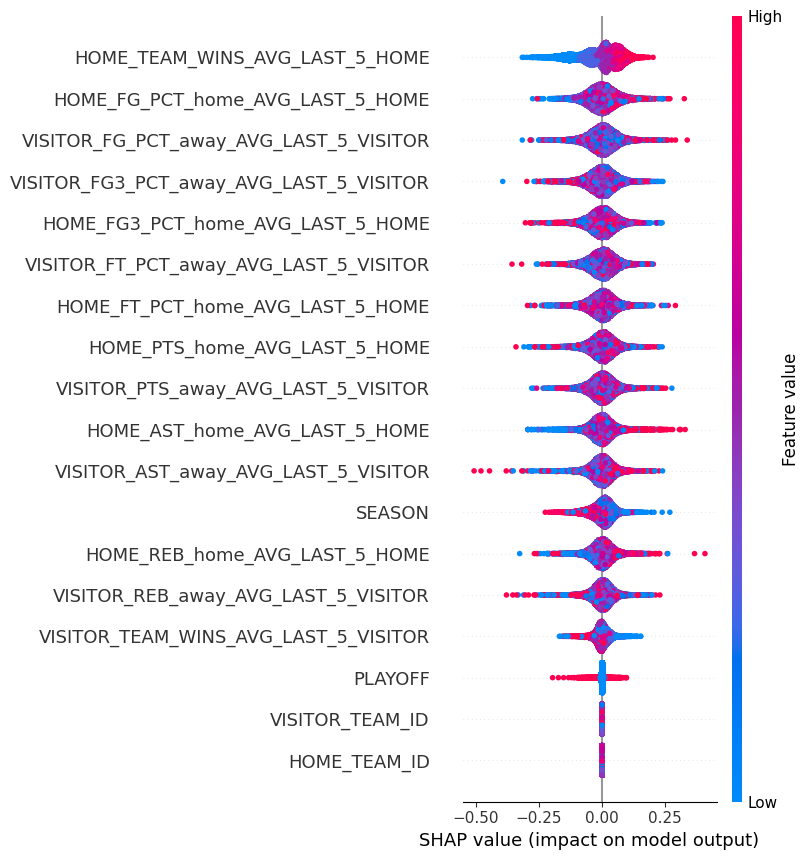

In [ ]:
# summarize the effects of all the features
shap.summary_plot(train_oof_shap[:,:-1], train)

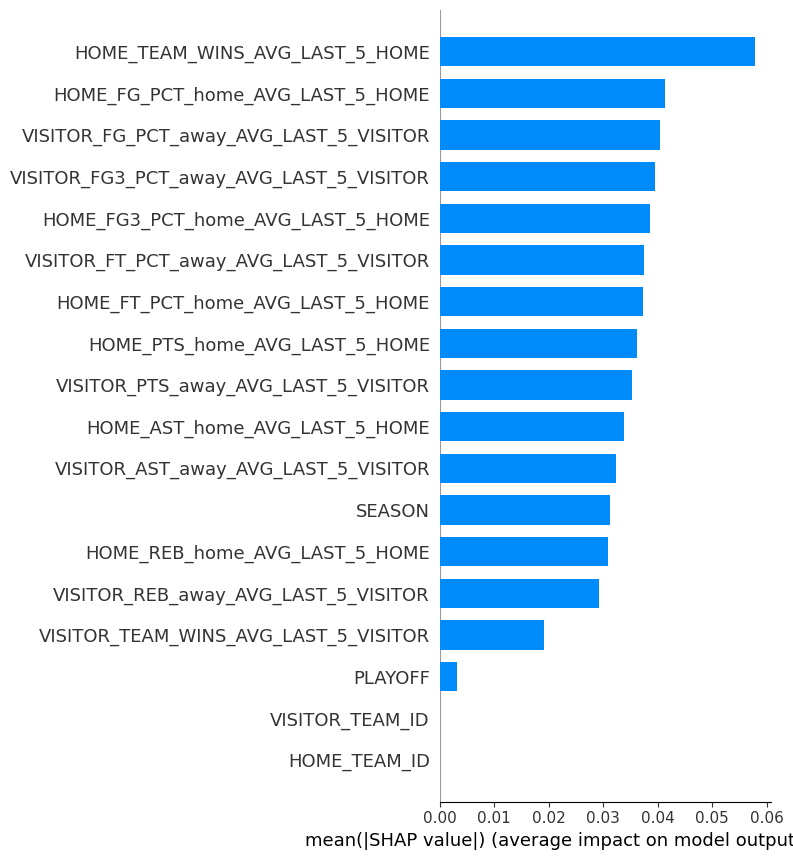

In [ ]:
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")

### Neural network

In [ ]:
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
import tensorflow as tf

current_time = str(time.time())

tensorboard = TensorBoard(log_dir='../../Logs/{}'.format(current_time))
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('../../Models/Trained-Model-ML-' + current_time, save_best_only=True, monitor='val_loss', mode='min')

finetune epochs

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from scikeras.wrappers import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(256, input_shape=(46,), kernel_initializer='uniform', activation='relu', kernel_regularizer=l2(0.01)))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.1))

 model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.1))

 model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

# create model
model = KerasClassifier(model=create_model, batch_size = 60, verbose=0)
# define the grid search parameters
# batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 30, 50, 100]
param_grid = dict(epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train, target)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

finetune dropout_rate

In [ ]:
def create_model(dropout_rate):
 # create model
 model = Sequential()
 model.add(Dense(256, input_shape=(46,), kernel_initializer='uniform', activation='relu', kernel_regularizer=l2(0.01)))
 model.add(BatchNormalization())
 model.add(Dropout(dropout_rate))

 model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(dropout_rate))

 model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
 return model

# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train, target)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

finetune learning_rate

In [ ]:
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(32, input_shape=(46,), kernel_initializer='uniform', activation='relu', kernel_regularizer=l2(0.01)))
 model.add(BatchNormalization())
 model.add(Dropout(0.3))

 model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(0.3))

 model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

 return model

# create model
model = KerasClassifier(model=create_model, loss='binary_crossentropy', optimizer='adagrad', epochs=60, batch_size=10, verbose=0)
# define the grid search parameters
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(optimizer__learning_rate=learning_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train, target)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

finetune number neurons

In [ ]:
def create_model(neurons):
 # create model
 model = Sequential()
 model.add(Dense(neurons * 2, input_shape=(46,), kernel_initializer='uniform', activation='relu', kernel_regularizer=l2(0.01)))
 model.add(BatchNormalization())
 model.add(Dropout(0.3))

 model.add(Dense(neurons, kernel_initializer='uniform', activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(0.3))

 model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
 return model

# create model
model = KerasClassifier(model=create_model, epochs=20, batch_size=32, verbose=0)
# define the grid search parameters
neurons = [4, 8, 16, 32, 64, 128, 256]
param_grid = dict(model__neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train, target)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

finetune optimizer 

In [ ]:
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(32, input_shape=(46,), kernel_initializer='uniform', activation='relu', kernel_regularizer=l2(0.01)))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.3))

 model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.3))

 model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
 return model

# create model
model = KerasClassifier(model=create_model, loss="binary_crossentropy", epochs=60, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = ['Adagrad']
param_grid = dict(optimizer=optimizer)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train, target)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [25]:
# from keras.regularizers import l2
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, BatchNormalization
# # Tạo mô hình
# model = Sequential()
# model.add(Dense(32, input_shape=(46,), kernel_initializer='uniform', activation='relu', kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(rate=0.3))

# model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(rate=0.3))

# model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# In ra tóm tắt của mô hình
model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)                │      1,504 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 32)                │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 32)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 16)                │        528 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 16)                │         64 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 16)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 1)                 │         17 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,145 (8.38 KB)

 Non-trainable params: 96 (384.00 B)